In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import timeit
from scipy.io import loadmat, savemat
%matplotlib inline

# DebtRank simulation


### Variables

- $A_i$: assets of node i
- $L_i$: liability of node i
- $E_i$: equity of node i
- $\Lambda_{i,j}$ leverage matrix

### Network construction

The network is generated by sampling each directed edge independently with probability:

$$p_{i\rightarrow j} = \dfrac{zA_iL_j}{1+zA_iL_j},$$

where $z$ is a parameter that tunes the density of edges.
Furthermore to each sampled edge we assign a weight given by:

$$w_{i\rightarrow j} = \dfrac{A_iL_j}{Wp_{i\rightarrow j}}$$

where $W = \sqrt{\sum_iA_i\sum_iL_i}$ 

### DebtRank simulation

We track the average equity loss of each node: 

$$h_i(t) = \dfrac{E_i(0) - E_i(t)}{E_i(0)}$$

DebtRank is updated at each timestep according to the following equation:

$$h_i(t+1) = min\left[1, h_i(t) + \sum_j\Lambda_{i,j}\left(h_j(t)-h_j(t-1)\right)\right]$$

In [6]:
def Get_Data(path, which, ranked):
    # Reads InterBank dataframe
    #== Parameters ==#
    # 1) path: string containing the path to the file with data about banks
    # 2) which: string assuming values '2008' or '2013'; selects either 2008 or 2013 data
    # 3) ranked: Boolean; if True the dataset is sorted according to Assets (in decreasing order)
    
    dfB = pd.read_excel(path)
    #dfB = pd.read_csv(path, float_precision='round_trip')
    
    dfB.columns = ['country', 'A8', 'L8', 'Atot8', 'E8', 'A13', 'L13', 'Atot13', 'E13']
    # select 2008 table
    if which=='2008':
        dfB2 = dfB[['A8','L8','Atot8','E8']].copy()
        dfB2.columns = ['A','L','Atot','E']
    elif which=='2013':
        dfB2 = dfB[['A13','L13','Atot13','E13']].copy()
        dfB2.columns = ['A','L','Atot','E']
    if ranked==True:
        dfB2.sort_values(ascending=False,by='Atot', inplace=True).reset_index(drop=True)
    return dfB2
def Get_P_W_UniformZ(df, Zp):
    # Returns the matrices P_{i->j} and W_{i->j}, i.e. the edge existence probability matrix 
    # and the matrix with all possible weighs
    #== Parameters ==#
    # 1) df: pandas dataframe containing assets and liabilities
    # 2) Zp: parameter z tuning network density
    As = df.A.values
    Ls = df.L.values
    tmp = np.outer(As,Ls)
    W = np.sqrt(np.sum(As)*np.sum(Ls)) # parameter W
    Pmatrix = Zp*tmp/(1+Zp*tmp) # P_{i->j} matrix
    Wmatrix = (1+Zp*tmp)/(W*Zp) # weight matrix
    return Pmatrix, Wmatrix
def Get_P_W_UniformZ_wrong(df, Zp):
    # Same as Get_P_W_UniformZ but the matrix W_{i->j} is wrong (it has not been divided by P_{i->j})
    As = df.A.values
    Ls = df.L.values
    tmp = np.outer(As,Ls)
    W = np.sqrt(np.sum(As)*np.sum(Ls)) # parameter W
    Pmatrix = Zp*tmp/(1+Zp*tmp) # P_{i->j} matrix
    Wmatrix = tmp/W # weight matrix
    return Pmatrix, Wmatrix

def Sample_Leverage(Pm, Wm, E0):
    # Samples leverage matrix
    #== Parameters ==#
    # 1) Pm: it's the P_{i->j} matrix
    # 2) Wm: it's the W_{i->j} matrix
    # 3) E0: array containing equities
    return np.random.binomial(1, Pm)*(Wm/E0[:,None])
def Initial_Shock(N, shocked_nodes, shock):
    # Applies the initial damage to the selected node and returns the initial equity loss
    #== Parameters =#
    # 1) N: number of nodes
    # 2) shocked_nodes: list of shocked nodes
    # 3) shock: amount of initial shock
    h0 = np.zeros(N)
    for node in shocked_nodes:
        h0[node] = shock
    return h0
def Compute_Loss(h, E0, h0):
    # Returns the total loss and eventually subtracts the initial loss
    #== Parameters ==#
    # 1) h: array containing fraction of equity loss 
    # 2) E0: initial equity
    # 3) h0: array containing initial fraction of equity loss; put array of zeros if taking into account initial damage too
    return(np.dot(h-h0,E0)/np.sum(E0))
def Detailed_Loss(h, E0, h0):
    # Returns the loss for each node and eventually subtracts the initial loss
    #== Parameters ==#
    # 1) h: array containing equity loss 
    # 2) E0: initial equity
    # 3) h0: array containing initial fraction of equity loss; put array of zeros if taking into account initial damage too
    if h0 == None:
        return((h*E0)/np.sum(E0))
    else:
        return(((h-h0)*E0)/np.sum(E0))

## Dependance of density on z

In [7]:
Density_A = []
N = 100
Zs = np.logspace(-12,-2,100) # array containing values of z to explore
dfB = Get_Data('Bankscope2_C72.xls','2008',False)

for z in Zs:
    Pm = Get_P_W_UniformZ(dfB, z)[0]
    Density_A.append(np.sum(Pm)/(N**2))

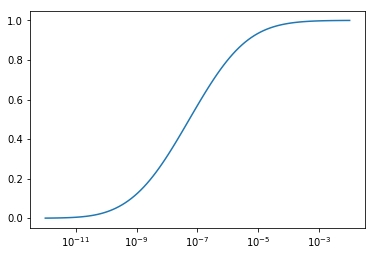

In [8]:
plt.plot(Zs, Density_A)
plt.xscale('log')

## Compare old vs new simulations

Compare results obtained with old code (bugged) and the new code (where weights are correctly taken into account)

In [9]:
# Read either 2008 or 2013 data

Tmax = 20000 # maximum iteration 
Nsim = 10 # number of simulations
N = 100 # network size
shocked = list(range(N)) # shock all nodes
Tol = 10**(-5) # numerical tolerance for stopping condition

Zs = np.logspace(-12,-2,100) # array containing values of z to explore

Shock_amount = np.arange(0.02,0.62,0.02) # array containing values of damage to explore

params = [('2008','old'), ('2008', 'new'), ('2013', 'old'), ('2013', 'new')]

for param in params:
    year, code_version = param
    dfB = Get_Data('Bankscope2_C72.xls', year, False)
    Results_Difference = [[[] for j in range(len(Zs))] for i in range(len(Shock_amount))]

    for iz, z in enumerate(Zs):
        if code_version == 'new':
            Pm, Wm = Get_P_W_UniformZ(dfB, z)
        elif code_version == 'old':
            Pm, Wm = Get_P_W_UniformZ_wrong(dfB, z)
        else:
            raise ValueError('code version not valid')
        E0 = dfB.E.values # get equity
        for ishock, shock in enumerate(Shock_amount):
            for sim  in range(Nsim):
                h_0 = Initial_Shock(N, shocked, shock) # initial shock
                h_old = np.zeros(N)
                h_t = h_0.copy()
                Adj = Sample_Leverage(Pm, Wm, E0) # sample leverage matrix 
                for t in range(1,Tmax):        
                    h_new = np.minimum(1., h_t + np.dot(Adj,h_t-h_old)) # Debtrank
                    h_old = h_t.copy()
                    h_t = h_new.copy()
                    if (np.linalg.norm((h_t-h_old)*E0) <= Tol or t >= Tmax):
                        Results_Difference[ishock][iz].append(Compute_Loss(h_t, E0, h_0)) 
                        break
    ResDiff_array = np.array(Results_Difference)
    savemat('h_{}_{}'.format(year, code_version),{'h_loss':ResDiff_array, 'z':Zs, 'Density':Density_A, 'Shock': Shock_amount})

In [10]:
# Load mat files with results simulations
Density_A = loadmat('h_2008_old')['Density']
Shock_amount = loadmat('h_2008_old')['Shock']
h_2008_old = loadmat('h_2008_old')['h_loss']
h_2008_new = loadmat('h_2008_new')['h_loss']
h_2013_old = loadmat('h_2013_old')['h_loss']
h_2013_new = loadmat('h_2013_new')['h_loss']

Text(0,0.5,'Shock')

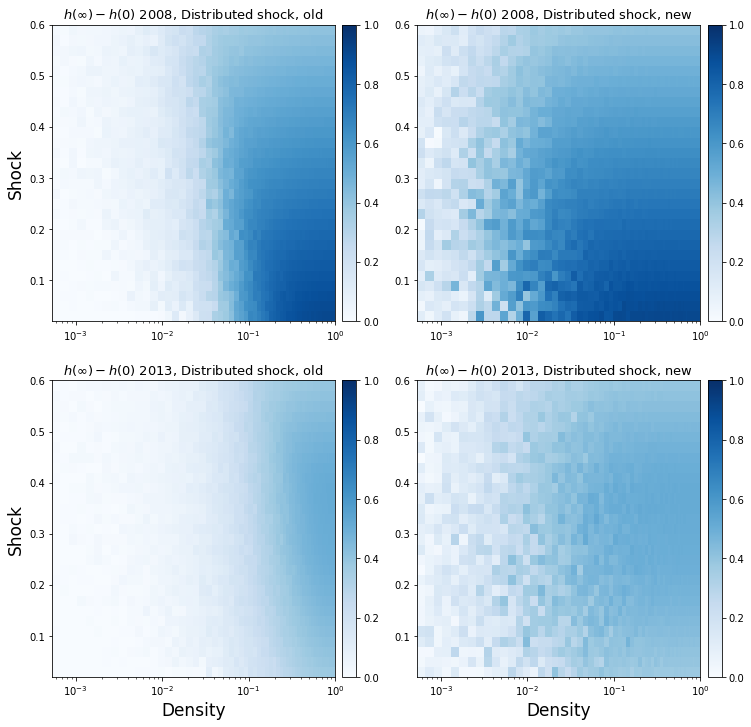

In [11]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12,12))

xx, yy = np.meshgrid(Density_A,Shock_amount)

############## FIRST PLOT 

im0 = ax[0][0].pcolormesh(xx,yy,np.mean(h_2008_old, axis=2),vmin=0,vmax=1,cmap='Blues')

# COLORBAR
divider0 = make_axes_locatable(ax[0][0])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
cbar0 = fig.colorbar(im0,cax0)
#cbar0.set_label('Average equity loss', rotation=270, fontsize = 14, labelpad=20)

ax[0][0].set_xscale('log')
ax[0][0].set_title(r'$h(\infty)-h(0)$'+' 2008, Distributed shock, old', fontsize=13)

# CONTOUR PLOTS
#CP0 = ax[0][0].contour(xx,yy,np.mean(h_2008_old, axis=2), [0.6,0.8,0.9], colors=['black','white','white'])
#ax[0][0].clabel(CP0,inline_spacing=0.2, inline=True, rightside_up=True,fmt = '%1.1f', fontsize=14, manual=[(0.05,0.1),(0.06,0.3),(0.08,0.4)])

############## SECOND PLOT 

im1 = ax[0][1].pcolormesh(xx,yy,np.mean(h_2008_new, axis=2),vmin=0,vmax=1,cmap='Blues')

# COLORBAR
divider1 = make_axes_locatable(ax[0][1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cbar1 = fig.colorbar(im1,cax1)
#cbar0.set_label('Average equity loss', rotation=270, fontsize = 14, labelpad=20)

ax[0][1].set_xscale('log')
ax[0][1].set_title(r'$h(\infty)-h(0)$'+' 2008, Distributed shock, new', fontsize=13)


############## THIRD PLOT 

im2 = ax[1][0].pcolormesh(xx,yy,np.mean(h_2013_old, axis=2),vmin=0,vmax=1,cmap='Blues')

# COLORBAR
divider2 = make_axes_locatable(ax[1][0])
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
cbar2 = fig.colorbar(im2,cax2)
#cbar0.set_label('Average equity loss', rotation=270, fontsize = 14, labelpad=20)

ax[1][0].set_xscale('log')
ax[1][0].set_title(r'$h(\infty)-h(0)$'+' 2013, Distributed shock, old', fontsize=13)


############## FOURTH PLOT 

im3 = ax[1][1].pcolormesh(xx,yy,np.mean(h_2013_new, axis=2),vmin=0,vmax=1,cmap='Blues')

# COLORBAR
divider3 = make_axes_locatable(ax[1][1])
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
cbar3 = fig.colorbar(im3,cax3)
#cbar0.set_label('Average equity loss', rotation=270, fontsize = 14, labelpad=20)

ax[1][1].set_xscale('log')
ax[1][1].set_title(r'$h(\infty)-h(0)$'+' 2013, Distributed shock, new', fontsize=13)


ax[1][0].set_xlabel('Density', fontsize=17)
ax[1][1].set_xlabel('Density', fontsize=17)
ax[0][0].set_ylabel('Shock', fontsize=17)
ax[1][0].set_ylabel('Shock', fontsize=17)

## Non-Linear DebtRank

In [144]:
Tmax = 20000
Nsim = 1000
N = 100
shock = 0.4
Tol = 10**(-5)

dfB = Get_Data('Bankscope2_C72.xls','2008',False)

Zs = np.logspace(-12,-2,100)
alphas = [0,4,6,6.25,6.5,6.75,7,1000]


Density_A = []
for z in Zs:
    Pm = Get_P_W_UniformZ(dfB, z)[0]
    Density_A.append(np.sum(Pm)/(N**2))

params = [('2008','old'), ('2008', 'new'), ('2013', 'old'), ('2013', 'new')]

for param in params:
    year, code_version = param
    dfB = Get_Data('Bankscope2_C72.xls', year, False)
    Results_Difference = [[[] for j in range(len(Zs))] for i in range(len(alphas))]

    for iz, z in enumerate(Zs):
        Pm, Wm = Get_P_W_UniformZ(dfB, z)
        #Pm, Wm = Get_P_W_UniformZ_wrong(dfB, z)
        E0 = dfB.E.values
        for ialpha, alpha in enumerate(alphas):
            for sim  in range(Nsim):
                h_0 = Initial_Shock(N, shocked, shock)
                h_old = np.zeros(N)
                h_t = h_0.copy()
                Adj = Sample_Leverage(Pm, Wm, E0)
                for t in range(1,Tmax):        
                    h_new = np.minimum(1., h_t + np.dot(Adj,h_t*np.exp(alpha*(h_t-1))-h_old*np.exp(alpha*(h_old-1))))
                    h_old = h_t.copy()
                    h_t = h_new.copy()
                    if (np.linalg.norm((h_t-h_old)*E0) <= Tol or t >= Tmax):
                        Results_Difference[ialpha][iz].append(Compute_Loss(h_t, E0, h_0)) 
                        break
    #Res_array = np.array(Results)
    ResDiff_array = np.array(Results_Difference)
    savemat('h_{}_NL_{}'.format(year, code_version),{'h_loss':ResDiff_array, 'z':Zs, 'Density':Density_A, 'Shock': shock, 'alpha':alphas})

In [100]:
Density_A = loadmat('h_2008_NL_old')['Density'][0]
alphas = loadmat('h_2008_NL_old')['alpha'][0]
h_2008_NL_old = loadmat('h_2008_NL_old')['h_loss']
h_2008_NL_new = loadmat('h_2008_NL_new')['h_loss']
h_2013_NL_old = loadmat('h_2013_NL_old')['h_loss']
h_2013_NL_new = loadmat('h_2013_NL_new')['h_loss']

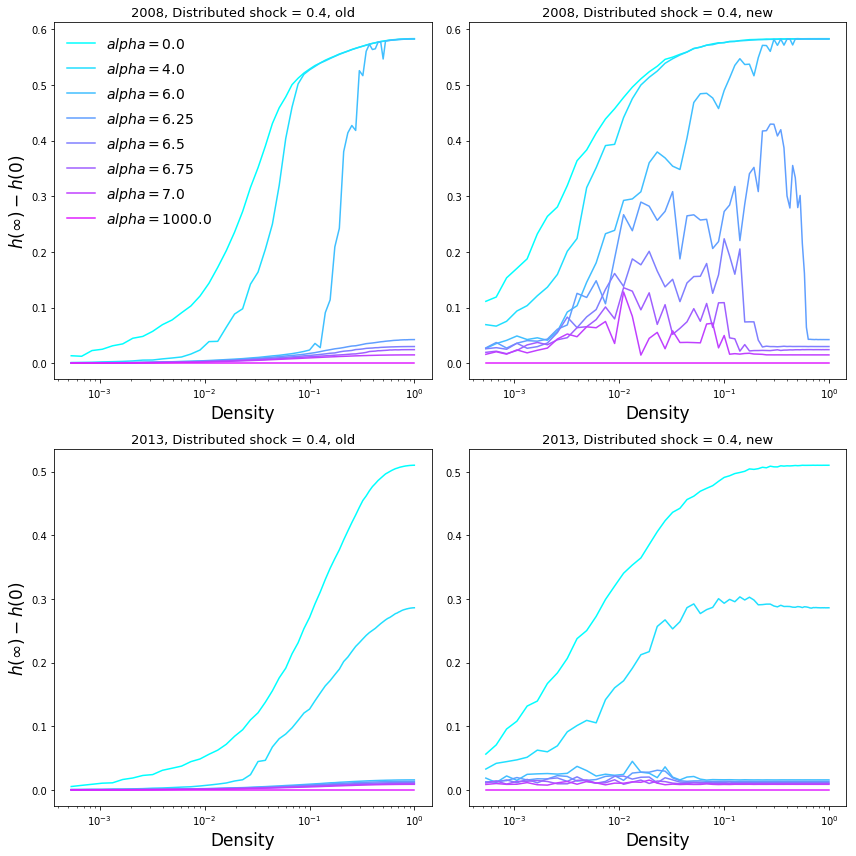

In [102]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12,12))

############## FIRST PLOT 


for ia,alpha in enumerate(alphas):
    ax[0][0].plot(Density_A, np.mean(h_2008_NL_old, axis=2)[ia,:], color = cm.cool(ia/len(alphas)), label=r'$alpha = {}$'.format(alpha))


ax[0][0].set_xscale('log')
ax[0][0].set_title('2008, Distributed shock = 0.4, old', fontsize=13)

# CONTOUR PLOTS
#CP0 = ax[0][0].contour(xx,yy,np.mean(h_2008_old, axis=2), [0.6,0.8,0.9], colors=['black','white','white'])
#ax[0][0].clabel(CP0,inline_spacing=0.2, inline=True, rightside_up=True,fmt = '%1.1f', fontsize=14, manual=[(0.05,0.1),(0.06,0.3),(0.08,0.4)])

############## SECOND PLOT 


for ia,alpha in enumerate(alphas):
    ax[0][1].plot(Density_A, np.mean(h_2008_NL_new, axis=2)[ia,:], color = cm.cool(ia/len(alphas)), label=r'$alpha = {}$'.format(alpha))

ax[0][1].set_xscale('log')
ax[0][1].set_title('2008, Distributed shock = 0.4, new', fontsize=13)


############## THIRD PLOT 


for ia,alpha in enumerate(alphas):
    ax[1][0].plot(Density_A, np.mean(h_2013_NL_old, axis=2)[ia,:], color = cm.cool(ia/len(alphas)), label=r'$\alpha = {}$'.format(alpha))


ax[1][0].set_xscale('log')
ax[1][0].set_title('2013, Distributed shock = 0.4, old', fontsize=13)


############## FOURTH PLOT 

for ia,alpha in enumerate(alphas):
    ax[1][1].plot(Density_A, np.mean(h_2013_NL_new, axis=2)[ia,:], color = cm.cool(ia/len(alphas)), label=r'$alpha = {}$'.format(alpha))

ax[1][1].set_xscale('log')
ax[1][1].set_title('2013, Distributed shock = 0.4, new', fontsize=13)


ax[0][0].legend(framealpha=False, fontsize = 14)

ax[1][0].set_xlabel('Density', fontsize=17)
ax[1][1].set_xlabel('Density', fontsize=17)
ax[0][0].set_ylabel(r'$h(\infty)-h(0)$', fontsize=17)
ax[1][0].set_ylabel(r'$h(\infty)-h(0)$', fontsize=17)
ax[0][0].set_xlabel('Density', fontsize=17)
ax[0][1].set_xlabel('Density', fontsize=17)

plt.tight_layout()

## NL debtrank results with larger statistics

In [ ]:
Tmax = 20000
Nsim = 1000
N = 100
shock = 0.4
Tol = 10**(-5)

dfB = Get_Data('Bankscope2_C72.xls','2008',False)

Zs = np.logspace(-12,-2,100)
#alphas = [0,2,3,4,5,6,6.5,7,1000]
#alphas = [0,4,6,6.25,6.5,6.75,7,1000]
alphas = [6.25,6.5,6.75,7]


Density_A = []
for z in Zs:
    Pm = Get_P_W_UniformZ(dfB, z)[0]
    Density_A.append(np.sum(Pm)/(N**2))

params = [('2008', 'new')]

for param in params:
    year, code_version = param
    dfB = Get_Data('Bankscope2_C72.xls', year, False)
    Results_Difference = [[[] for j in range(len(Zs))] for i in range(len(alphas))]

    for iz, z in enumerate(Zs):
        Pm, Wm = Get_P_W_UniformZ(dfB, z)
        #Pm, Wm = Get_P_W_UniformZ_wrong(dfB, z)
        E0 = dfB.E.values
        for ialpha, alpha in enumerate(alphas):
            for sim  in range(Nsim):
                h_0 = Initial_Shock(N, shocked, shock)
                h_old = np.zeros(N)
                h_t = h_0.copy()
                Adj = Sample_Leverage(Pm, Wm, E0)
                for t in range(1,Tmax):        
                    h_new = np.minimum(1., h_t + np.dot(Adj,h_t*np.exp(alpha*(h_t-1))-h_old*np.exp(alpha*(h_old-1))))
                    h_old = h_t.copy()
                    h_t = h_new.copy()
                    if (np.linalg.norm((h_t-h_old)*E0) <= Tol or t >= Tmax):
                        Results_Difference[ialpha][iz].append(Compute_Loss(h_t, E0, h_0)) 
                        break
    #Res_array = np.array(Results)
    ResDiff_array = np.array(Results_Difference)
    savemat('h_{}_NL_{}_1000runs'.format(year, code_version),{'h_loss':ResDiff_array, 'z':Zs, 'Density':Density_A, 'Shock': shock, 'alpha':alphas})

In [306]:
Density_A = loadmat('h_2008_NL_new_1000runs')['Density'][0]
alphas = loadmat('h_2008_NL_new_1000runs')['alpha'][0]
h_2008_NL_new_1000runs = loadmat('h_2008_NL_new_1000runs')['h_loss']

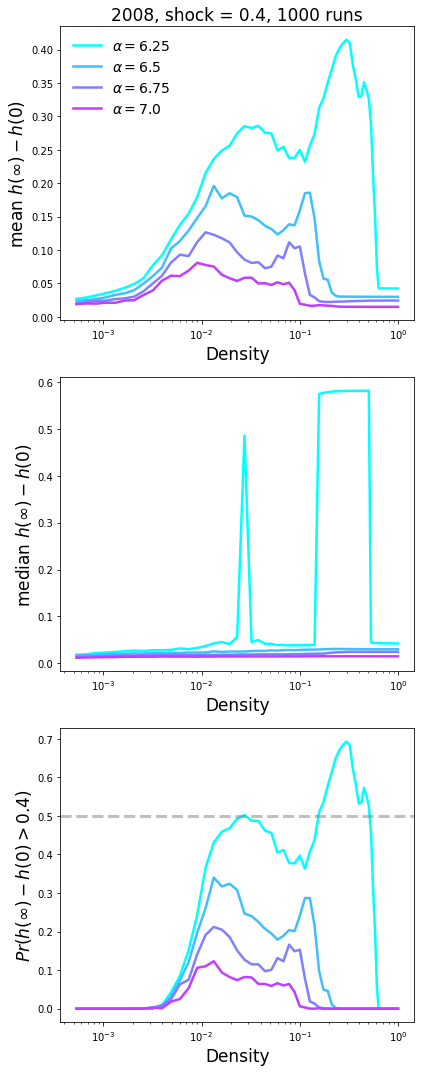

In [307]:
fig, ax = plt.subplots(nrows=3,figsize=(6,15))

############## FIRST PLOT 

for ia,alpha in enumerate(alphas):
    average = np.mean(h_2008_NL_new_1000runs, axis=2)[ia,:]
    median = np.median(h_2008_NL_new_1000runs, axis=2)[ia,:]
    
    #perc_down = np.percentile(h_2008_NL_new_1000runs, q=25, axis=2)[ia,:]
    #perc_up = np.percentile(h_2008_NL_new_1000runs, q =75, axis=2)[ia,:]
    
    ax[0].plot(Density_A, average, color = cm.cool(ia/len(alphas)), label=r'$\alpha = {}$'.format(alpha), lw = 2.5)
    ax[1].plot(Density_A, median, color = cm.cool(ia/len(alphas)), label=r'$\alpha = {}$'.format(alpha), lw = 2.5)
    
    prob_up = []
    for aa, Da in enumerate(Density_A):
        greater = h_2008_NL_new_1000runs[ia,aa]
        prob_up.append(len(greater[greater>0.4])/Nruns)
    ax[2].plot(Density_A, prob_up, color = cm.cool(ia/len(alphas)), label=r'$\alpha = {}$'.format(alpha), lw = 2.5)
    #ax.fill_between(Density_A, perc_down, perc_up, color = cm.cool(ia/len(alphas)), alpha=0.3)
    #ax[2].axvline(x=1/alpha,ls='--',lw=2.5,color=cm.cool(ia/len(alphas)), alpha=0.4)

ax[2].axhline(y=0.5, color='grey', ls='--', lw=3, alpha=0.5)


ax[0].set_xscale('log')
ax[1].set_xscale('log')
ax[2].set_xscale('log')


ax[0].set_ylabel('mean ' + r'$h(\infty)-h(0)$', fontsize=17)
ax[1].set_ylabel('median ' + r'$h(\infty)-h(0)$', fontsize=17)
ax[2].set_ylabel(r'$Pr(h(\infty)-h(0) > 0.4)$', fontsize=17)

ax[0].set_xlabel('Density', fontsize=17)
ax[1].set_xlabel('Density', fontsize=17)
ax[2].set_xlabel('Density', fontsize=17)

ax[0].set_title('2008, shock = 0.4, 1000 runs', fontsize=17)

ax[0].legend(framealpha=False, fontsize=14)

plt.tight_layout()

### Equity loss distribution

Plot the distribution of final equity loss obtained from multiple simulations and for a given parameter set

Text(0.5,1,'$Density = 0.987,\\alpha = 6.25$')

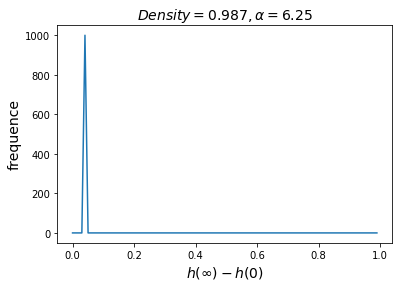

In [271]:
# Get distribution of equity loss

# choose parameter values 
ia = 0 # index of alpha
aa = 80 # index of z

biins = np.linspace(0,1,100)
Nruns = len(h_2008_NL_new_1000runs[ia,aa])
histo,bins_extrema = np.histogram(h_2008_NL_new_1000runs[ia,aa], bins = biins)
plt.plot(biins[:-1],histo)

plt.xlabel(r'$h(\infty)-h(0)$', fontsize=14)
plt.ylabel('frequence', fontsize=14)
plt.title(r'$Density = {},\alpha = {}$'.format(round(Density_A[aa],3),alphas[ia]), fontsize=14)
#plt.xscale('log')

## Temporal evolution

Check the transient evolution of the system

In [23]:
Tmax = 15
Nsim = 50
N = 100
shocked = list(range(N))
Tol = 10**(-5)

Zs = np.logspace(-12,-2,50)
Density_A = []
for z in Zs:
    Pm = Get_P_W_UniformZ(dfB, z)[0]
    Density_A.append(np.sum(Pm)/(N**2))

Shock_amount = np.arange(0.02,0.62,0.04)

params = [('2008','old'), ('2008', 'new'), ('2013', 'old'), ('2013', 'new')]

for param in params:
    year, code_version = param
    dfB = Get_Data('Bankscope2_C72.xls', year, False)

    Results_Difference = [[[[] for t in range(Tmax)] for j in range(len(Zs))] for i in range(len(Shock_amount))]

    for iz, z in enumerate(Zs):
        Pm, Wm = Get_P_W_UniformZ(dfB, z)
        E0 = dfB.E.values
        for ishock, shock in enumerate(Shock_amount):
            for sim  in range(Nsim):
                h_0 = Initial_Shock(N, shocked, shock)
                h_old = np.zeros(N)
                h_t = h_0.copy()
                Adj = Sample_Leverage(Pm, Wm, E0)
                for t in range(0,Tmax):        
                    Results_Difference[ishock][iz][t].append(Compute_Loss(h_t, E0, h_0)) 
                    h_new = np.minimum(1., h_t + np.dot(Adj,h_t-h_old))
                    h_old = h_t.copy()
                    h_t = h_new.copy()
    ResDiff_array = np.array(Results_Difference)
    savemat('h_{}_temp_{}'.format(year, code_version),{'h_loss':ResDiff_array, 'z':Zs, 'Density':Density_A, 'Shock': Shock_amount})

In [24]:
Density_A = loadmat('h_2008_temp_old')['Density'][0]
Shock_amount = loadmat('h_2008_temp_old')['Shock'][0]
h_2008_temp_old = loadmat('h_2008_temp_old')['h_loss']
h_2008_temp_new = loadmat('h_2008_temp_new')['h_loss']
h_2013_temp_old = loadmat('h_2013_temp_old')['h_loss']
h_2013_temp_new = loadmat('h_2013_temp_new')['h_loss']

(0, 0.4)

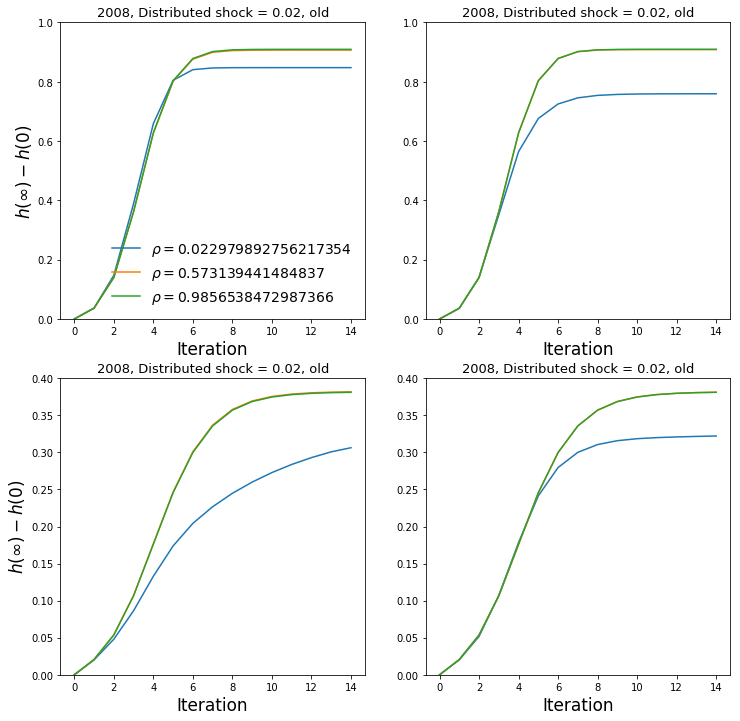

In [27]:
shock = 0
densities = [10,25,40]

fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize=(12,12))

############## FIRST PLOT 

for iD in densities:
    ax[0][0].plot(np.mean(h_2008_temp_old, axis=3)[shock,iD], label=r'$\rho = {}$'.format(Density_A[iD]))
    
############## SECOND PLOT 

for iD in densities:
    ax[0][1].plot(np.mean(h_2008_temp_new, axis=3)[shock,iD], label=r'$\rho = {}$'.format(Density_A[iD]))
    
############## THIRD PLOT 

for iD in densities:
    ax[1][0].plot(np.mean(h_2013_temp_old, axis=3)[shock,iD], label=r'$\rho = {}$'.format(Density_A[iD]))

############## THIRD PLOT 

for iD in densities:
    ax[1][1].plot(np.mean(h_2013_temp_new, axis=3)[shock,iD], label=r'$\rho = {}$'.format(Density_A[iD]))

ax[0][0].set_title('2008, Distributed shock = {}, old'.format(Shock_amount[shock]), fontsize=13)
ax[0][1].set_title('2008, Distributed shock = {}, old'.format(Shock_amount[shock]), fontsize=13)
ax[1][0].set_title('2008, Distributed shock = {}, old'.format(Shock_amount[shock]), fontsize=13)
ax[1][1].set_title('2008, Distributed shock = {}, old'.format(Shock_amount[shock]), fontsize=13)


ax[0][0].legend(framealpha=False, fontsize = 14)

ax[1][0].set_xlabel('Iteration', fontsize=17)
ax[1][1].set_xlabel('Iteration', fontsize=17)
ax[0][0].set_ylabel(r'$h(\infty)-h(0)$', fontsize=17)
ax[1][0].set_ylabel(r'$h(\infty)-h(0)$', fontsize=17)
ax[0][0].set_xlabel('Iteration', fontsize=17)
ax[0][1].set_xlabel('Iteration', fontsize=17)
ax[0][0].set_ylim(0,1)
ax[0][1].set_ylim(0,1)
ax[1][0].set_ylim(0,0.4)
ax[1][1].set_ylim(0,0.4)

In [28]:
h_2008_firstIter = h_2008_temp_new[:,:,1,:]
h_2013_firstIter = h_2013_temp_new[:,:,1,:]

Text(0.5,1,'$h(2)-h(0)$ 2013, Distributed shock')

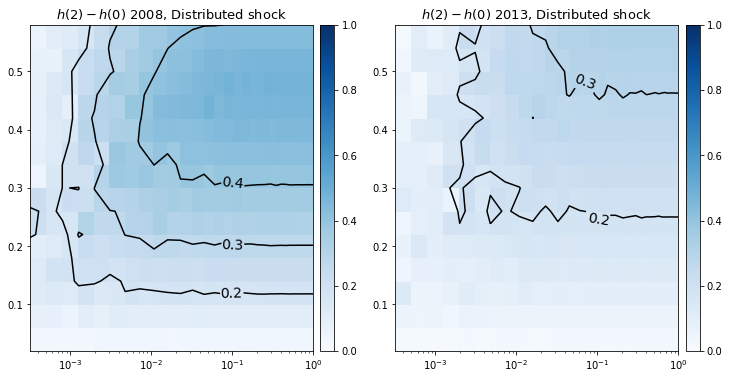

In [29]:
fig, ax = plt.subplots(ncols = 2, figsize=(12,6))

xx, yy = np.meshgrid(Density_A,Shock_amount)

############## FIRST PLOT 

im0 = ax[0].pcolormesh(xx,yy,np.mean(h_2008_firstIter, axis=2),vmin=0,vmax=1,cmap='Blues')

# COLORBAR
divider0 = make_axes_locatable(ax[0])
cax0 = divider0.append_axes("right", size="5%", pad=0.1)
cbar0 = fig.colorbar(im0,cax0)
#cbar0.set_label('Average equity loss', rotation=270, fontsize = 14, labelpad=20)

ax[0].set_xscale('log')
ax[0].set_title(r'$h(2)-h(0)$'+' 2008, Distributed shock', fontsize=13)

# CONTOUR PLOTS
CP0 = ax[0].contour(xx,yy,np.mean(h_2008_firstIter, axis=2), [0.2,0.3,0.4], colors=['black','black','black'])
ax[0].clabel(CP0,inline_spacing=0.2, inline=True, rightside_up=True,fmt = '%1.1f', fontsize=14,manual=[(0.1,0.1),(0.1,0.2),(0.1,0.3)])

############## SECOND PLOT 

im1 = ax[1].pcolormesh(xx,yy,np.mean(h_2013_firstIter, axis=2),vmin=0,vmax=1,cmap='Blues')

# COLORBAR
divider1 = make_axes_locatable(ax[1])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)
cbar1 = fig.colorbar(im1,cax1)
#cbar0.set_label('Average equity loss', rotation=270, fontsize = 14, labelpad=20)
CP1 = ax[1].contour(xx,yy,np.mean(h_2013_firstIter, axis=2), [0.2,0.3], colors=['black','black'])
ax[1].clabel(CP1,inline_spacing=0.2, inline=True, rightside_up=True,fmt = '%1.1f', fontsize=14,manual=[(0.1,0.2),(0.1,0.5)])

ax[1].set_xscale('log')
ax[1].set_title(r'$h(2)-h(0)$'+' 2013, Distributed shock', fontsize=13)

## NL debtrank, first iteration

In [283]:
Tmax = 2
Nsim = 1000
N = 100
shock = 0.4
Tol = 10**(-5)
#Shock_amount = np.linspace(0,0.6,20)
#Zs = np.logspace(-10,-2,50)

dfB = Get_Data('Bankscope2_C72.xls','2013',False)

Zs = np.logspace(-12,-2,100)
alphas = [6.25,6.5,6.75,7]


Density_A = []
for z in Zs:
    Pm = Get_P_W_UniformZ(dfB, z)[0]
    Density_A.append(np.sum(Pm)/(N**2))

params = [('2008', 'new'), ('2013', 'new')]

for param in params:
    year, code_version = param
    dfB = Get_Data('Bankscope2_C72.xls', year, False)

    Results_Difference = [[[[] for t in range(Tmax)] for j in range(len(Zs))] for i in range(len(alphas))]

    for iz, z in enumerate(Zs):
        Pm, Wm = Get_P_W_UniformZ(dfB, z)
        #Pm, Wm = Get_P_W_UniformZ_wrong(dfB, z)
        E0 = dfB.E.values
        for ialpha, alpha in enumerate(alphas):
            for sim  in range(Nsim):
                h_0 = Initial_Shock(N, shocked, shock)
                h_old = np.zeros(N)
                h_t = h_0.copy()
                Adj = Sample_Leverage(Pm, Wm, E0)
                for t in range(0,2):
                    Results_Difference[ialpha][iz][t].append(Compute_Loss(h_t, E0, h_0)) 
                    h_new = np.minimum(1., h_t + np.dot(Adj,h_t*np.exp(alpha*(h_t-1))-h_old*np.exp(alpha*(h_old-1))))
                    h_old = h_t.copy()
                    h_t = h_new.copy()
                    if (t >= 1):
                        #Results[ishock][iz].append(Compute_Loss(h_t, E0, np.zeros(N)))
                        break
    #Res_array = np.array(Results)
    ResDiff_array = np.array(Results_Difference)
    savemat('h_{}_NL_firstIter'.format(year),{'h_loss':ResDiff_array, 'z':Zs, 'Density':Density_A, 'Shock': shock, 'alpha':alphas})

In [289]:
Density_A = loadmat('h_2008_NL_firstIter')['Density'][0]
alphas = loadmat('h_2008_NL_firstIter')['alpha'][0]
h_2008_NL_firstIter = loadmat('h_2008_NL_firstIter')['h_loss'][:,:,1,:]
h_2013_NL_firstIter = loadmat('h_2013_NL_firstIter')['h_loss'][:,:,1,:]

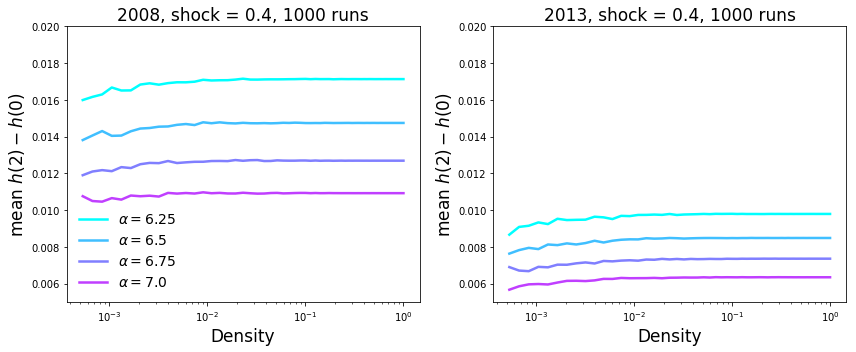

In [293]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5))

############## FIRST PLOT 

for ia,alpha in enumerate(alphas):
    average = np.mean(h_2008_NL_firstIter, axis=2)[ia,:]    
    ax[0].plot(Density_A, average, color = cm.cool(ia/len(alphas)), label=r'$\alpha = {}$'.format(alpha), lw = 2.5)
    average = np.mean(h_2013_NL_firstIter, axis=2)[ia,:]    
    ax[1].plot(Density_A, average, color = cm.cool(ia/len(alphas)), label=r'$\alpha = {}$'.format(alpha), lw = 2.5)    

ax[0].set_ylim(0.005,0.02)
ax[1].set_ylim(0.005,0.02)

ax[0].set_xscale('log')
ax[1].set_xscale('log')

ax[0].set_ylabel('mean ' + r'$h(2)-h(0)$', fontsize=17)
ax[1].set_ylabel('mean ' + r'$h(2)-h(0)$', fontsize=17)

ax[0].set_xlabel('Density', fontsize=17)
ax[1].set_xlabel('Density', fontsize=17)

ax[0].set_title('2008, shock = 0.4, 1000 runs', fontsize=17)
ax[1].set_title('2013, shock = 0.4, 1000 runs', fontsize=17)

ax[0].legend(framealpha=False, fontsize=14)

plt.tight_layout()